## Intro à RLlib

In [1]:
# HIDDEN
import gym
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

In [2]:
# HIDDEN
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR); # logging.FATAL

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### Et l'apprentissage ?

Revenons à l'"API" de RL :

[](img/RL-API.png)

- Nous avons parlé de l'entrée (environnement) et de la sortie (politique)
- Parlons maintenant de l'apprentissage par renforcement !

#### Ce que nous allons couvrir

- Il existe de très nombreux algorithmes d'apprentissage supervisé... forêts aléatoires, régression logistique, réseaux neuronaux, etc.
- De même, il existe de nombreux algorithmes RL.
- Ce n'est pas un cours sur les algorithmes RL, même s'il en existe beaucoup de bons !
- Ce cours porte sur _l'application_ de RL.

#### Présentation de Ray RLlib

[](img/rllib-logo.png)

- Dans ce cours, nous utiliserons Ray RLlib comme notre "scikit-learn de l'apprentissage par renforcement"
- Nous ne regarderons sous le capot que si nécessaire, et nous nous concentrerons sur les entrées et les sorties.

#### Notre premier code RLlib

- Tout d'abord, nous importons RLlib
- RLlib fait partie du projet Ray, d'où `ray`
- Dans ce cours, nous nous concentrerons principalement sur l'algorithme [PPO] (https://openai.com/blog/openai-baselines-ppo/), d'où `PPO`.

In [3]:
from ray.rllib.algorithms.ppo import PPO

Ensuite, nous créons un objet formateur 

In [4]:
# HIDDEN
algo_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True)\
    .debugging(seed=0, log_level="ERROR", logger_config={"log_to_driver" : False})\
    .training(model={"fcnet_hiddens" : [32, 32]})\
    .environment(env_config={"is_slippery" : False})
)

In [5]:
ppo = PPO(env="FrozenLake-v1", config=algo_config)

- `PPO` : nous utilisons l'algorithme PPO
- `env="FrozenLake-v1"` : RLlib connaît les environnements OpenAI Gym
  - Dans le prochain module, nous apprendrons à créer nos propres environnements !
- `config=algo_config` : cela contient tous les hyperparamètres de l'algorithme et de l'environnement.
  - Pour plus de clarté, nous avons caché la config pour l'instant, mais nous y reviendrons bientôt.
  
Remarques :

- Nous pouvons faire référence aux environnements de gymnastique par leur nom
- Plus tard, nous montrerons la nouvelle façon standard d'instancier les algorithmes

#### Utiliser la politique

- Nous n'avons pas encore formé l'agent, mais nous pouvons quand même voir ce qu'il fait.
- C'est comme appeler `predict` avant d'exécuter `fit` avec l'apprentissage supervisé.

In [6]:
env = gym.make("FrozenLake-v1", is_slippery=False)
obs = env.reset(seed=3)
obs

0

In [7]:
# HIDDEN
from utils_02 import fix_frozen_lake_render
fix_frozen_lake_render(env)

In [8]:
action = ppo.compute_single_action(obs, explore=False)
action

2

- Nous avons donné à l'algorithme notre observation initiale, 0, et il a recommandé l'action 2 (à droite).
- Cette action provenait de la **politique** initialisée.
- Rappelle-toi que la politique fait correspondre les observations aux actions.
- Pour l'instant, nous allons ignorer le `explore=False`.

#### Utiliser la politique

Nous pouvons voir ce qui s'est passé après avoir pris cette mesure :

In [9]:
obs, reward, done, _ = env.step(action)
env.render()

  (Right)
.P..
.O.O
...O
O..G


#### Formation

- Jusqu'à présent, notre politique n'était qu'une initialisation aléatoire/arbitraire.
- Ce que nous voulons, c'est l'entraîner _en se basant sur l'expérience d'interaction avec l'environnement_.
- Pour ce faire, RLlib va _jouer de nombreux épisodes_ et apprendre au fur et à mesure.

In [10]:
train_info = ppo.train()

- Note que, contrairement à `fit()` de sklearn, ici nous ne fournissons pas l'ensemble de données à `train()`.
- Nous lui avons donné l'environnement pendant l'initialisation, et il utilise l'environnement pour générer des données.

Notes :

La méthode `train` renvoie un dictionnaire contenant des informations sur l'itération de la formation. Nous l'explorerons ensuite.

#### Itérations de formation

- En fait, ce que nous venons de faire était une _itération_ de formation.
- RLlib passera par plusieurs épisodes par itération, en fonction de ses hyperparamètres.

In [11]:
len(train_info["hist_stats"]["episode_lengths"])

536

On dirait qu'il y a eu ~500 épisodes dans cette seule itération.

In [12]:
sum(train_info["hist_stats"]["episode_lengths"])

3991

Pour un total de ~4000 pas de temps.

#### L'état d'esprit RL : génération de données

- Principale différence avec la mentalité de l'apprentissage supervisé
- Dans l'apprentissage supervisé, nous prenons une quantité fixe de données et nous nous entraînons pendant un certain nombre d'itérations
- En RL, plus d'itérations signifie plus d'entraînement _sur plus de données_ car nous apprenons de l'environnement au fur et à mesure que nous interagissons avec lui
- Si tu ne joues qu'un seul épisode, tu ne verras peut-être jamais l'observation 10, alors comment peux-tu apprendre ce qu'il faut faire à partir de l'observation 10 ?

#### L'état d'esprit de RL

Ce que nous avions avant, lorsque nous contrôlions l'agent manuellement :

![](img/RL-loop-2.png)

#### L'état d'esprit de RL

Ce que nous avons maintenant :

![](img/RL-loop-3.png)

Nous avons une boucle externe qui implique la formation.

Notes :

L'entraînement / la mise à jour de l'agent n'a pas nécessairement lieu après chaque itération, mais ce schéma donne un cadre conceptuel.

#### Infos sur la formation : longueurs des épisodes

Regardons les longueurs des 100 derniers épisodes auxquels nous avons joué :

In [13]:
print(train_info["hist_stats"]["episode_lengths"][-100:])

[4, 9, 18, 3, 5, 2, 5, 5, 13, 18, 4, 6, 9, 3, 16, 4, 2, 3, 8, 4, 4, 4, 9, 6, 7, 2, 3, 6, 10, 9, 5, 7, 11, 19, 4, 7, 2, 2, 15, 6, 2, 10, 6, 13, 10, 11, 3, 10, 2, 8, 14, 12, 2, 4, 5, 2, 7, 4, 7, 5, 2, 3, 2, 6, 7, 2, 19, 2, 4, 12, 15, 7, 7, 11, 6, 2, 6, 6, 12, 6, 16, 8, 8, 4, 8, 4, 6, 4, 16, 2, 5, 11, 10, 6, 14, 2, 2, 6, 4, 14]


- Rappelle-toi qu'un épisode se termine lorsque `.step()` renvoie `True` pour l'indicateur `done`.
- Nous voyons des épisodes très courts, où l'agent est tombé dans un trou tout de suite.

#### Infos sur l'entraînement : récompenses d'épisodes

- Pour ces épisodes plus longs, l'agent a-t-il atteint l'objectif ?
- Pour l'évaluer, nous pouvons imprimer les 100 premières _récompenses d'épisodes_ :

In [14]:
print(train_info["hist_stats"]["episode_reward"][-100:])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Et la moyenne de ces récompenses :

In [15]:
print(np.mean(train_info["hist_stats"]["episode_reward"][-100:]))

0.03


Ce n'est pas très impressionnant. Continuons à nous entraîner.

#### Plus de formation

In [16]:
for i in range(10):
    train_info = ppo.train()

In [17]:
print(np.mean(train_info["hist_stats"]["episode_reward"]))

0.9778481012658228


- Super ! Maintenant, nous atteignons l'objectif presque à chaque fois !
- La _récompense moyenne_ (sur les épisodes d'entraînement les plus récents) est de ~0,98.
- Interprétation : nous atteignons l'objectif 98% du temps.

Notes :

Pourquoi cette interprétation ? Parce que dans cet environnement, nous ne recevons une récompense qu'à la fin de l'épisode, 0 pour un échec et 1 pour une réussite.

#### Courbes de formation

- En apprentissage profond, nous voyons souvent des diagrammes de perte par rapport aux époques pendant l'entraînement
- Nous pouvons obtenir cela en RL aussi en stockant ceci à chaque itération :

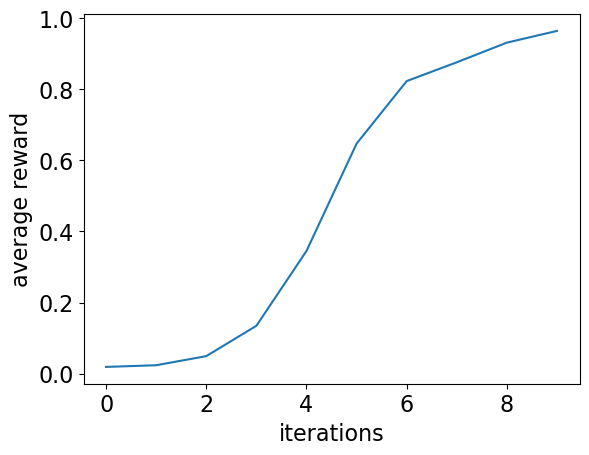

In [18]:
ppo = PPO(env="FrozenLake-v1", config=algo_config)

rewards = []
for i in range(10):
    train_info = ppo.train()
    rewards.append(train_info["episode_reward_mean"])
                   
import matplotlib.pyplot as plt
plt.plot(rewards);
plt.xlabel("iterations");
plt.ylabel("average reward");

Nous pouvons voir que les récompenses augmentent !

Remarques : Si nous stockons la moyenne de récompense des épisodes pour chaque itération de formation, nous pouvons pr

#### Déclare la victoire ?

- Nous avons bien fait.
- Mais ce lac gelé non glissant est un environnement très facile 
- Un peu comme un ensemble de données d'apprentissage supervisé où y=x serait "facile".
- Plus tard, nous augmenterons la difficulté.

#### Utiliser la politique

Nous pouvons exécuter la **boucle d'observation-politique-action** pendant plusieurs pas de temps pour observer la politique en action :

In [19]:
obs = env.reset()

for i in range(3):
    action = ppo.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()

  (Down)
....
PO.O
...O
O..G
  (Down)
....
.O.O
P..O
O..G
  (Right)
....
.O.O
.P.O
O..G


Notes :

La méthode de formation pertinente dans RLlib est compute_single_action

#### Utiliser la politique

In [20]:
for i in range(3):
    action = ppo.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()

  (Right)
....
.O.O
..PO
O..G
  (Down)
....
.O.O
...O
O.PG
  (Right)
....
.O.O
...O
O..P


En utilisant cette politique, nous atteignons le but de manière fiable à chaque fois, car l'environnement non glissant de Frozen Lake est déterministe.

#### Évaluation

Dans RLlib, nous pouvons évaluer avec `.evaluate()` :

In [21]:
eval_results = ppo.evaluate()

La formation n'a pas lieu pendant l'évaluation.

In [22]:
eval_results["evaluation"]["episode_reward_mean"]

0.9501557632398754

Ici, nous obtenons des résultats similaires à la sortie de `.train()`, mais pas exactement les mêmes 

Notes :

La sortie d'évaluation contient beaucoup d'informations, y compris plusieurs des mêmes champs que la sortie de formation.

#### Évaluation

Histogramme des récompenses d'épisodes :

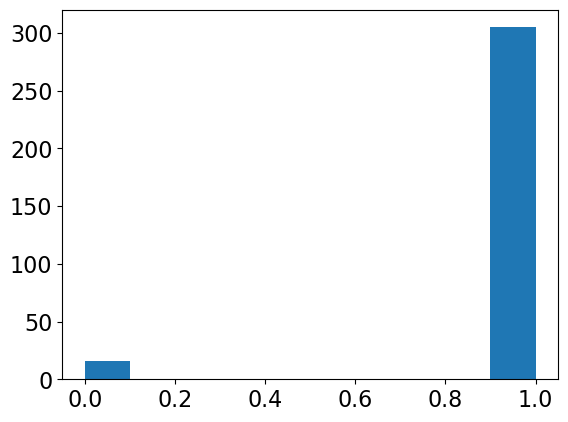

In [23]:
plt.hist(eval_results["evaluation"]["hist_stats"]["episode_reward"]);

#### Évaluation

Histogramme des _longueurs_ d'épisode :

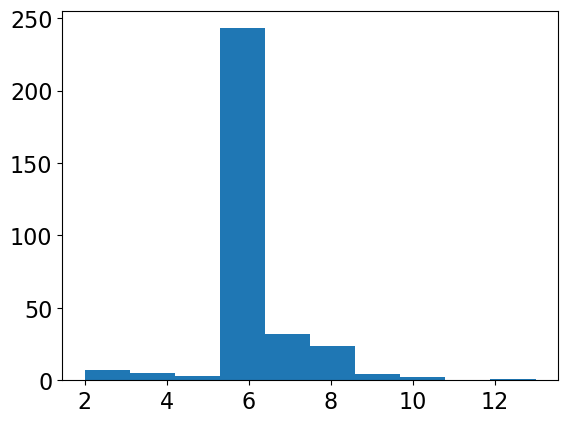

In [24]:
plt.hist(eval_results["evaluation"]["hist_stats"]["episode_lengths"]);

- Les plus courtes sont les échecs, car il est impossible d'atteindre le but en 4 étapes.
- La plupart du temps, nous atteignons le but en un nombre minimum d'étapes (6).

#### analogies sklearn / RLlib

- Nous avons vu quelques analogies (et départs) entre SL et RL, tant au niveau du concept que de la syntaxe 
- Comparons :

| SL/sklearn | RL/RLlib | Description |
|-------------|---------|--------------|
| `ModelName(**hypers)` | `AlgoName(hypers, env)` | Initialiser un modèle/algorithme |
| `.fit(X,y)` | `.train()` | Formation (entièrement pour sklearn, une itération pour RLlib) |
| `.predict(x)` | `.compute_single_action(obs)` | Utiliser une fois le modèle formé |
| `.score(X,y)` | `.evaluate()` | Évaluer le modèle |

#### Appliquons ce que nous avons appris !

## Méthodes de l'algorithme RLlib
<!-- multiple choice -->

#### Formation

lequel des énoncés suivants décrit le mieux le rôle de `algorithm.train()` dans RLlib ?

- [ ] Il ne collecte pas un ensemble de données d'épisodes et n'apprend pas de politique. | Es-tu sûr ?
- [ ] Il apprend une politique à partir d'un ensemble de données fixe d'épisodes. | Rappelle-toi que le fait d'appeler train() oblige l'agent à lire les épisodes.
- [ ] Il crée un ensemble de données d'épisodes mais n'apprend pas de politique. | Rappelle-toi qu'en appelant train(), l'agent apprend une politique.
- [x] Il collecte simultanément un ensemble de données d'épisodes et apprend également une politique. | Tu as trouvé !

#### Passage dans l'ensemble de données

lorsque nous utilisons scikit-learn pour l'apprentissage supervisé, nous appelons `fit(X,y)`, mais avec RLlib nous appelons `train()` sans passer dans l'ensemble de données. Pourquoi ?

- [ ] Parce que RLlib a eu accès à l'environnement lors de l'initialisation de l'algorithme, et c'est tout ce dont il a besoin.
- [ ] Parce que l'apprentissage par renforcement n'implique pas de données.
- [ ] Parce que X et y sont passés dans une méthode RLlib différente.

#### Prédire

_Quelle est la méthode de l'algorithme RLlib suivante qui est la plus analogue à la fonction `.predict()` de scikit-learn ?

- [ ] train() | Cela ressemble plus à _fit()_ dans scikit-learn.
- [x] compute_single_action()
- [ ] evaluate() | Cela ressemble plus à _score()_ dans scikit-learn 

## Lac glissant et gelé
<!-- coding exercise -->

Dans les diapositives, nous avons entraîné un agent à atteindre le but de manière fiable dans l'environnement **non glissant** Frozen Lake. Ici, essaie de faire la même chose avec le lac gelé **glissant**. Entraîne ton agent pendant suffisamment d'itérations pour qu'il atteigne l'objectif au moins 20 % du temps. Ensuite, réponds à la question à choix multiple ci-dessous.

Remarque : nous discuterons de la configuration de l'algorithme dans la prochaine série de diapositives. Pour l'instant, note simplement que nous utilisons la version glissante de Frozen Lake.

In [25]:
# EXERCISE
from ray.rllib.algorithms.ppo import PPO, PPOConfig
from utils_02 import slippery_algo_config

ppo = PPO(env=____, config=slippery_algo_config)

for i in range(____):
    train_info = ppo.____()
    
eval_results = ____.evaluate()

print(eval_results["evaluation"]["episode_reward_mean"])

NameError: name '____' is not defined

In [30]:
# SOLUTION
from ray.rllib.algorithms.ppo import PPO
from utils_02 import slippery_algo_config

ppo = PPO(env="FrozenLake-v1", config=slippery_algo_config)

for i in range(50): # There is randomness here, but 20+ should be enough most of the time
    train_info = ppo.train()
    
eval_results = ppo.evaluate()

print("Frequency of reaching goal: %.1f%%" % (eval_results["evaluation"]["episode_reward_mean"]*100))

print("Action performed from top-right:", ppo.compute_single_action(3, explore=False))

Frequency of reaching goal: 87.0%
Action performed from top-right: 3


#### Action effectuée à partir du haut et de la droite

Selon la politique formée, quelle action est exécutée lorsque l'agent se trouve en haut à droite de l'arène ? Ceci est imprimé par le code.

- [ ] gauche (0) | Lorsque nous avons exécuté le code, nous avons obtenu quelque chose de différent ici.
- [ ] down (1) | Lorsque nous avons exécuté le code, nous avons obtenu quelque chose de différent ici.
- [ ] droite (2) | Lorsque nous avons exécuté le code, nous avons obtenu quelque chose de différent ici.
- [ ] haut (3) | Tu as réussi !

#### Interpréter la politique

Rappelle-toi que l'arène ressemble à ceci :

```
SFFF
FHFH
FFFH
HFFG
```

Dans cet environnement glissant, tu fais ton action prévue 1/3 du temps, et chacune des deux directions perpendiculaires 1/3 du temps. Tu ne vas jamais dans la direction opposée à celle prévue.

Dans la question précédente, nous avons vu que, depuis le **coin supérieur droit** (observation 3), l'agent essaie de se déplacer vers le haut (action 3). À ton avis, pourquoi l'agent essaie-t-il de se déplacer vers le haut ?

- [ ] "Vers le haut" est un choix arbitraire car nous n'avons pas formé l'agent.
- [ ] L'agent reçoit une récompense pour l'action 'vers le haut' 
- [ ] L'agent veut éviter de tomber dans le trou en dessous de lui, donc l'action 'vers le haut' est le choix le plus sûr.
- [ ] Le fait de se déplacer vers le haut rapproche l'agent de l'objectif.

In [31]:
# # HIDDEN

# from ray.rllib.algorithms.ppo import PPO, PPOConfig
# from utils_02 import slippery_algo_config

# ppo = slippery_algo_config.build(env="FrozenLake-v1")

# for i in range(20):
#     ppo.train()

# ppo.save("models/FrozenLakeSlippery20")

## Rendre l'agent formé
<!-- coding exercise -->

Remplis les espaces vides du code ci-dessous pour que le code exécute la boucle observation-action-récompense pendant un épisode. Ensuite, exécute le code et regarde l'agent entraîné naviguer sur le lac gelé glissant. Ensuite, réponds à la question à choix multiple ci-dessous.

In [32]:
# EXERCISE
from ray.rllib.algorithms.ppo import PPO
from utils_02 import slippery_algo_config
import gym
from IPython import display
import time

ppo = PPO(env="FrozenLake-v1", config=slippery_algo_config)
ppo.restore("models/FrozenLakeSlippery50/checkpoint_000050/")

env = gym.make("FrozenLake-v1", is_slippery=True)

obs = env.reset()
env.seed(12)

done = False
while not done:
    action = ppo.compute_single_action(obs, explore=False)
    obs, rewards, done, _ = env.step(action)

    display.clear_output(wait=True);
    print(env.render(mode="ansi"))
    time.sleep(0.25)

  (Down)
SFFF
FHFH
FFFH
HFFG



In [34]:
# SOLUTION
from ray.rllib.algorithms.ppo import PPO
from utils_02 import slippery_algo_config
import gym
from IPython import display
import time

ppo = PPO(env="FrozenLake-v1", config=slippery_algo_config)
ppo.restore("models/FrozenLakeSlippery50/checkpoint_000050/")

env = gym.make("FrozenLake-v1", is_slippery=True)

obs = env.reset()
env.seed(12)

done = False
while not done:
    action = ppo.compute_single_action(obs, explore=False)
    obs, rewards, done, _ = env.step(action)

    display.clear_output(wait=True);
    print(env.render(mode="ansi"))
    time.sleep(0.25)

  (Down)
SFFF
FHFH
FFFH
HFFG



#### Choisis l'option ci-dessous qui décrit le mieux le voyage périlleux de l'agent vers le but.

- [ ] L'agent visite la case en haut à droite dans cet épisode.
- [ ] L'agent ne revient jamais à l'état de départ après l'avoir quitté initialement.
- [ ] L'agent n'atteint pas le but pendant l'épisode.
- [ ] L'agent ne voit jamais l'observation 10 pendant son voyage.